In [40]:
import pandas as pd
import folium
from folium.plugins import HeatMap
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import csv

In [41]:
data = pd.read_csv('data.csv')
data = data.rename(columns={'opis': 'natezenie'})

data[['lat', 'lon']] = data['WKT'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)')
data['lon'] = data['lon'].astype(float)
data['lat'] = data['lat'].astype(float)

# 4. Filtrowanie danych: tylko te, które mają 'natezenie' różne od NaN
filteredData = data[data['natezenie'].notna()]
filteredData['natezenie'] = filteredData['natezenie'].astype(float)
filteredData

,WKT,nazwa,natezenie,lat,lon
0,POINT (19.9139996 50.0656149),Punkt 1,67.2,19.914000,50.065615
1,POINT (19.9139567 50.0655038),Punkt 2,56.2,19.913957,50.065504
2,POINT (19.9139166 50.0654074),Punkt 3,52.8,19.913917,50.065407
3,POINT (19.9138793 50.0653039),Punkt 4,58.7,19.913879,50.065304
4,POINT (19.9138444 50.0651937),Punkt 8,57.9,19.913844,50.065194
...,...,...,...,...,...
70,POINT (19.9149346 50.0654192),Punkt 86,65.4,19.914935,50.065419
71,POINT (19.9147039 50.0654691),Punkt 87,70.5,19.914704,50.065469
72,POINT (19.9144907 50.0655156),Punkt 88,70.8,19.914491,50.065516
73,POINT (19.9143351 50.0655466),Punkt 89,64.7,19.914335,50.065547


In [42]:
my_inten = np.array([30.6, 57.9, 73.5, 81.6, 88.2])
ref_inten = np.array([25.5, 54.3, 67.1, 76.9, 81.4])

In [43]:
def calibration_curve(intensity, a, b, c):
    return a*np.power(intensity, 2) + b*intensity + c

[-1.85513204e-03  1.19296051e+00 -9.17242976e+00]


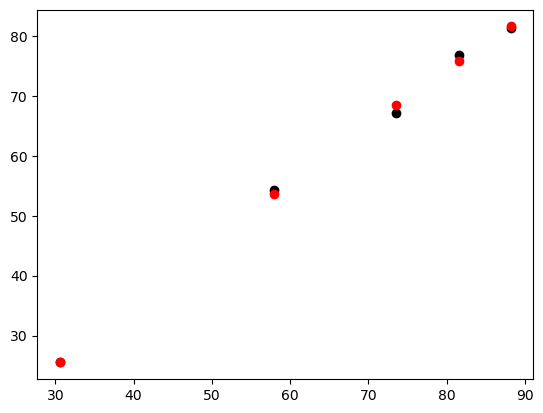

In [44]:
popt, _ = curve_fit(calibration_curve, xdata = my_inten, ydata = ref_inten, p0=[0.1, 0.5, 1])
print(popt)
plt.plot(my_inten, ref_inten, marker = 'o', linestyle = '', color = 'black')
plt.plot(my_inten, calibration_curve(my_inten, popt[0], popt[1], popt[2]), marker = 'o', linestyle = '', color = 'red')

In [45]:
filteredData['natezenie'] = calibration_curve(filteredData['natezenie'], popt[0], popt[1], popt[2])
filteredData

,WKT,nazwa,natezenie,lat,lon
0,POINT (19.9139996 50.0656149),Punkt 1,62.617037,19.914000,50.065615
1,POINT (19.9139567 50.0655038),Punkt 2,52.012627,19.913957,50.065504
2,POINT (19.9139166 50.0654074),Punkt 3,48.644074,19.913917,50.065407
3,POINT (19.9138793 50.0653039),Punkt 4,54.462142,19.913879,50.065304
4,POINT (19.9138444 50.0651937),Punkt 8,53.680820,19.913844,50.065194
...,...,...,...,...,...
70,POINT (19.9149346 50.0654192),Punkt 86,60.912491,19.914935,50.065419
71,POINT (19.9147039 50.0654691),Punkt 87,65.710816,19.914704,50.065469
72,POINT (19.9144907 50.0655156),Punkt 88,65.990065,19.914491,50.065516
73,POINT (19.9143351 50.0655466),Punkt 89,60.246365,19.914335,50.065547


In [59]:
intensity = []
longitude = []
latitude = []
modeledData = [intensity, longitude, latitude]

for i in range(len(filteredData['natezenie']) - 1): 
    intensity.append(filteredData['natezenie'][i])
    intensityMean = 0.5 * (filteredData['natezenie'][i] + filteredData['natezenie'][i+1])
    intensity.append(intensityMean)

    longitude.append(filteredData['lon'][i])
    longitudeMean = 0.5 * (filteredData['lon'][i] + filteredData['lon'][i+1])
    longitude.append(longitudeMean)

    latitude.append(filteredData['lat'][i])
    latitudeMean = 0.5 * (filteredData['lat'][i] + filteredData['lat'][i+1])
    latitude.append(latitudeMean)

filename = "interpolated_data.csv"
with open(filename, mode = "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerows(list(zip(*modeledData)))

In [47]:
map = folium.Map(location=[50.0625, 19.9230], zoom_start=15)
heat_data = [[lon, lat, inten] for lon, lat, inten in zip(longitude, latitude, intensity)]
HeatMap(heat_data, radius=20).add_to(map)
map.save("mapkatest.html")
map


In [48]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap

# Wczytanie pliku CSV
data = pd.read_csv('data.csv')

# Zmiana nazwy kolumny
data = data.rename(columns={'opis': 'natezenie'})

# Wyodrębnienie współrzędnych z kolumny WKT
data[['lon', 'lat']] = data['WKT'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)')
data['lon'] = data['lon'].astype(float)
data['lat'] = data['lat'].astype(float)

# Filtrowanie danych: tylko te, które mają 'natezenie' różne od NaN
filteredData = data[data['natezenie'].notna()]
filteredData['natezenie'] = filteredData['natezenie'].astype(float)

# Tworzymy nową listę punktów z średnimi punktami pomiędzy każdymi sąsiednimi punktami
new_points = []

# Iteracja przez punkty w zbiorze, tworzenie nowych punktów pomiędzy każdymi dwiema kolejnymi
for i in range(len(filteredData) - 1):
    # Punkt i
    point1 = filteredData.iloc[i]
    lat1, lon1, natezenie1 = point1['lat'], point1['lon'], point1['natezenie']
    
    # Punkt i+1
    point2 = filteredData.iloc[i + 1]
    lat2, lon2, natezenie2 = point2['lat'], point2['lon'], point2['natezenie']
    
    # Obliczanie średnich współrzędnych i wartości
    mid_lat = (lat1 + lat2) / 2
    mid_lon = (lon1 + lon2) / 2
    mid_natezenie = (natezenie1 + natezenie2) / 2
    
    # Dodanie średniego punktu do listy
    new_points.append([mid_lat, mid_lon, mid_natezenie])

# Dodanie oryginalnych punktów i nowych punktów do mapy
all_points = filteredData[['lat', 'lon', 'natezenie']].values.tolist() + new_points

# Przygotowanie mapy
map = folium.Map(location=[50.0625, 19.9230], zoom_start=16)

# Dodanie HeatMap na mapę
HeatMap(all_points, radius=15).add_to(map)

# Zapis mapy do pliku HTML
map.save("mapka_z_srednimi_punktami.html")
map
data

,WKT,nazwa,natezenie,lon,lat
0,POINT (19.9139996 50.0656149),Punkt 1,67.2,19.914000,50.065615
1,POINT (19.9139567 50.0655038),Punkt 2,56.2,19.913957,50.065504
2,POINT (19.9139166 50.0654074),Punkt 3,52.8,19.913917,50.065407
3,POINT (19.9138793 50.0653039),Punkt 4,58.7,19.913879,50.065304
4,POINT (19.9138444 50.0651937),Punkt 8,57.9,19.913844,50.065194
...,...,...,...,...,...
70,POINT (19.9149346 50.0654192),Punkt 86,65.4,19.914935,50.065419
71,POINT (19.9147039 50.0654691),Punkt 87,70.5,19.914704,50.065469
72,POINT (19.9144907 50.0655156),Punkt 88,70.8,19.914491,50.065516
73,POINT (19.9143351 50.0655466),Punkt 89,64.7,19.914335,50.065547


In [49]:
print(filteredData.natezenie)

0     67.2
1     56.2
2     52.8
3     58.7
4     57.9
      ... 
70    65.4
71    70.5
72    70.8
73    64.7
74    67.1
Name: natezenie, Length: 75, dtype: float64
